In [82]:
!pip install split-folders

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import torch
import shutil
import glob
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [84]:
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
folder_path = "/content/drive/MyDrive/tom_and_jerry"
files = os.listdir(folder_path)

# Display files
for file in files:
    print(file)


tom_jerry_1
jerry
tom
tom_jerry_0


In [86]:
# Define the original dataset path
original_data_path = "/content/drive/MyDrive/tom_and_jerry"
backup_data_path = "/content/drive/MyDrive/original_tom_and_jerry"

# Copy dataset before splitting
if not os.path.exists(backup_data_path):
    shutil.copytree(original_data_path, backup_data_path)
    print("Backup dataset created successfully!")
else:
    print("Backup dataset already exists.")

Backup dataset created successfully!


In [87]:
data_dir='/content/drive/MyDrive/tom_and_jerry'
data_dir=pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output="tom_and_jerry", seed=41, ratio=(.8,.2))

Copying files: 5478 files [01:57, 46.47 files/s] 


In [88]:
data_dir='/content/tom_and_jerry'
data_dir=pathlib.Path(data_dir)

In [89]:
data_dir

PosixPath('/content/tom_and_jerry')

In [90]:
transform=transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [91]:
train_set= torchvision.datasets.ImageFolder(data_dir.joinpath('train'),transform=transform)
train_set.transform
val_set= torchvision.datasets.ImageFolder(data_dir.joinpath('val'),transform=transform)
val_set.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [92]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 4382
    Root location: /content/tom_and_jerry/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [93]:
print(val_set)

Dataset ImageFolder
    Number of datapoints: 1096
    Root location: /content/tom_and_jerry/val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


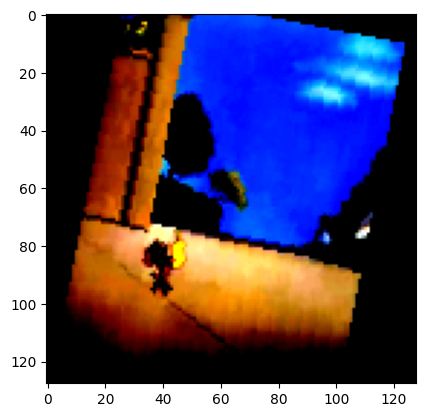

In [94]:
img,label= train_set[100]
plt.imshow(img.permute(1,2,0))

In [95]:
batch_size=100
train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_loader=torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

In [96]:
next(iter(train_loader))[0].shape

torch.Size([100, 3, 128, 128])

In [97]:
next(iter(val_loader))[0].shape

torch.Size([100, 3, 128, 128])

In [98]:
class CNNModel(nn.Module):
  def _get_flattened_size(self):
      """Pass a dummy tensor through the conv layers to calculate the flattened size."""
      dummy_input = torch.randn(1, 3, 128, 128)  # (batch_size, channels, height, width)
      out = self.maxpool1(self.leaky_relu(self.conv1(dummy_input)))
      out = self.maxpool2(self.leaky_relu(self.conv2(out)))
      out = self.maxpool3(self.leaky_relu(self.conv3(out)))
      out = self.maxpool4(self.leaky_relu(self.conv4(out)))
      return out.view(1, -1).size(1)  # Compute flattened size dynamically

  def __init__(self):
    super(CNNModel,self).__init__()

    #Conv1
    self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=1)    #128-5+1=124

    #Maxpool 1
    self.maxpool1=nn.MaxPool2d(kernel_size=2)   #124/2 = 62

    #Conv2
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=1)   #62-5+1= 58

    #Maxpool 2
    self.maxpool2=nn.MaxPool2d(kernel_size=2)   #58/2 = 29

    #Conv3
    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=1)   #29-5+1= 25

    #Maxpool 3
    self.maxpool3=nn.MaxPool2d(kernel_size=2)   #25/2 = 12

    #Conv4
    self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding=1)    #12-5+1= 8

    #Maxpool 4
    self.maxpool4=nn.MaxPool2d(kernel_size=2)   #8/2= 4

    #Activation Function
    self.leaky_relu=nn.LeakyReLU()

    #Automatically determine the flattened size
    self.flattened_size = self._get_flattened_size()

    #Fully connected alyer 1
    self.fc1=nn.Linear(self.flattened_size,1024)

    #Fully connected alyer 2
    self.fc2=nn.Linear(1024,4)



  def forward(self,x):
    #layer 1
    out=self.leaky_relu(self.conv1(x))
    out=self.maxpool1(out)

    #layer 2
    out=self.leaky_relu(self.conv2(out))
    out=self.maxpool2(out)

    #layer 3
    out=self.leaky_relu(self.conv3(out))
    out=self.maxpool3(out)

    #layer 4
    out=self.leaky_relu(self.conv4(out))
    out=self.maxpool4(out)

    #Flatten

    out=out.view(out.size(0), -1)

    #Linear Function

    out=self.leaky_relu(self.fc1(out))
    out=self.fc2(out)

    return out


In [99]:
#Training CNN
num_epochs=20
model=CNNModel()
error=nn.CrossEntropyLoss()
lr=0.001
optimizer=optim.Adam(model.parameters(),lr=lr)
scheduler=ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5)

In [100]:
train_loss_list=[]
val_loss_list=[]
accuracy_list=[]

for epoch in range(num_epochs):
  train_loss=0.0
  val_loss=0.0
  accuracy=0.0
  for i,(images,labels) in enumerate(train_loader):
    outputs=model(images)
    loss=error(outputs,labels)
    optimizer.zero_grad()
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("loss in iteration: ",i,": ",loss.item())
  total=0
  correct=0
  for images,labels in val_loader:
    outputs=model(images)
    v_loss=error(outputs,labels)
    val_loss+=v_loss.item()
    predicted=torch.max(outputs.data,1)[1]

    total+=labels.size(0)
    correct+=(predicted==labels).sum()

  scheduler.step(val_loss/len(val_loader))
  accuracy=100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)

  print("Epoch:{} Loss:{} Accuracy:{}%".format(epoch+1,train_loss/len(train_loader),accuracy))

loss in iteration:  0 :  1.3901623487472534
loss in iteration:  1 :  1.5705550909042358
loss in iteration:  2 :  1.376145362854004
loss in iteration:  3 :  1.3803471326828003
loss in iteration:  4 :  1.3888403177261353
loss in iteration:  5 :  1.3898870944976807
loss in iteration:  6 :  1.3782485723495483
loss in iteration:  7 :  1.3819007873535156
loss in iteration:  8 :  1.3483270406723022
loss in iteration:  9 :  1.349310040473938
loss in iteration:  10 :  1.3842424154281616
loss in iteration:  11 :  1.332425594329834
loss in iteration:  12 :  1.3398971557617188
loss in iteration:  13 :  1.3180941343307495
loss in iteration:  14 :  1.312953233718872
loss in iteration:  15 :  1.2912594079971313
loss in iteration:  16 :  1.3434536457061768
loss in iteration:  17 :  1.2857714891433716
loss in iteration:  18 :  1.3301233053207397
loss in iteration:  19 :  1.326809287071228
loss in iteration:  20 :  1.3732993602752686
loss in iteration:  21 :  1.3347549438476562
loss in iteration:  22 : 

In [101]:
train_loss_list

[1.3348287614909085,
 1.2043023976412686,
 0.9979122660376809,
 0.9271132471886548,
 0.8549953428181735,
 0.8162459907206622,
 0.7746755101464011,
 0.7309478223323822,
 0.6952741511843421,
 0.6874586343765259,
 0.652211111377586,
 0.6037136343392459,
 0.6202469529076056,
 0.5520051880316301,
 0.5051440210504965,
 0.46762718937613745,
 0.46465827185999264,
 0.4195952462879094,
 0.4049845324321227,
 0.370974756099961]

In [102]:
val_loss_list

[1.3012873259457676,
 1.0336921594359658,
 0.9589030580087141,
 0.9350280544974587,
 0.8875731988386675,
 0.8383108594200828,
 0.7943355766209689,
 0.8024839162826538,
 0.8012520183216442,
 0.8136421712962064,
 0.7425204623829235,
 0.7777934236959978,
 0.6855020983652635,
 0.6719980402426287,
 0.598386591131037,
 0.662736253304915,
 0.5770813985304399,
 0.6055021286010742,
 0.5695250549099662,
 0.5546355220404539]

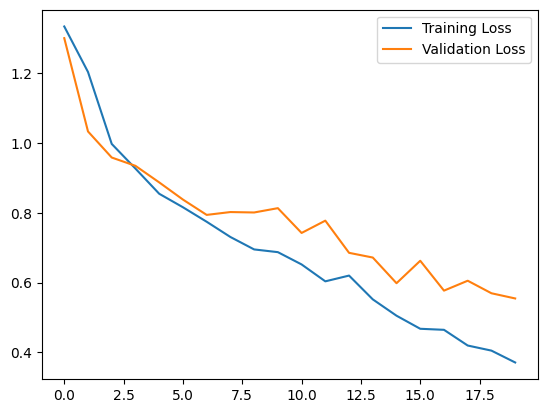

In [103]:
plt.plot(range(num_epochs),train_loss_list,label="Training Loss")
plt.plot(range(num_epochs),val_loss_list,label="Validation Loss")
plt.legend()
plt.show()

In [104]:
accuracy_list

[tensor(37.6825),
 tensor(51.9161),
 tensor(56.4781),
 tensor(58.0292),
 tensor(59.5803),
 tensor(63.8686),
 tensor(65.4197),
 tensor(64.9635),
 tensor(64.8723),
 tensor(66.6058),
 tensor(69.0693),
 tensor(68.6131),
 tensor(73.0839),
 tensor(72.9015),
 tensor(75.6387),
 tensor(73.5401),
 tensor(77.7372),
 tensor(78.1022),
 tensor(79.7445),
 tensor(80.5657)]

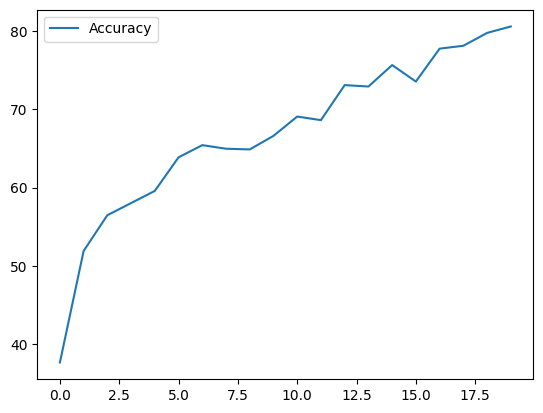

In [105]:
plt.plot(range(num_epochs),accuracy_list,label="Accuracy")
plt.legend()
plt.show()

1


Text(0.5, 1.0, '1')

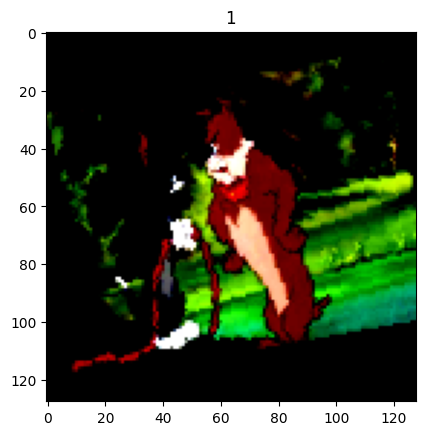

In [106]:
img,label=train_set[1000]
plt.imshow(img.permute(1,2,0))
print(label)
plt.title(label)

In [107]:
image=img.unsqueeze(0)

with torch.no_grad():
  output=model(image)
_,pred=torch.max(output,1)
print("Predicted output: ",pred.item())
# Check if prediction is correct
if label == pred.item():
    print("✅ Model predicted correctly!")
else:
    print("❌ Model predicted incorrectly.")

Predicted output:  1
✅ Model predicted correctly!


0


Text(0.5, 1.0, '0')

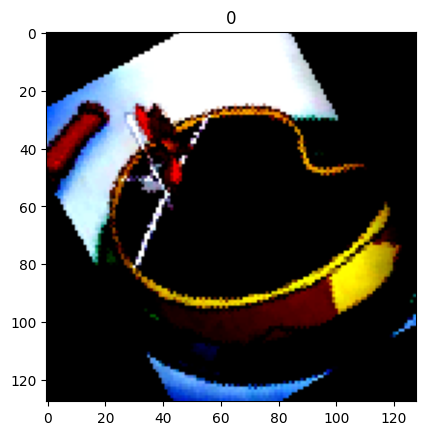

In [125]:
img,label=train_set[300]
plt.imshow(img.permute(1,2,0))
print(label)
plt.title(label)

In [126]:
image=img.unsqueeze(0)

with torch.no_grad():
  output=model(image)
_,pred=torch.max(output,1)
print("Predicted output: ",pred.item())
# Check if prediction is correct
if label == pred.item():
    print("✅ Model predicted correctly!")
else:
    print("❌ Model predicted incorrectly.")

Predicted output:  0
✅ Model predicted correctly!


3


Text(0.5, 1.0, '3')

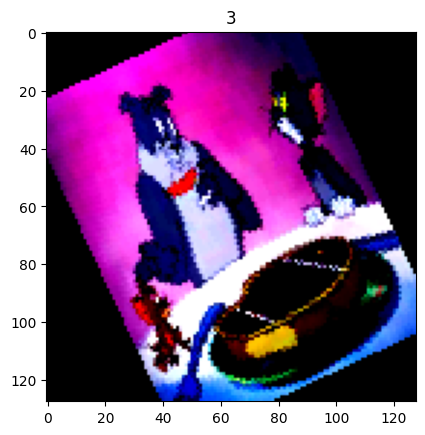

In [129]:
img,label=val_set[1000]
plt.imshow(img.permute(1,2,0))
print(label)
plt.title(label)

In [130]:
image=img.unsqueeze(0)

with torch.no_grad():
  output=model(image)
_,pred=torch.max(output,1)
print("Predicted output: ",pred.item())
# Check if prediction is correct
if label == pred.item():
    print("✅ Model predicted correctly!")
else:
    print("❌ Model predicted incorrectly.")

Predicted output:  3
✅ Model predicted correctly!


1


Text(0.5, 1.0, '1')

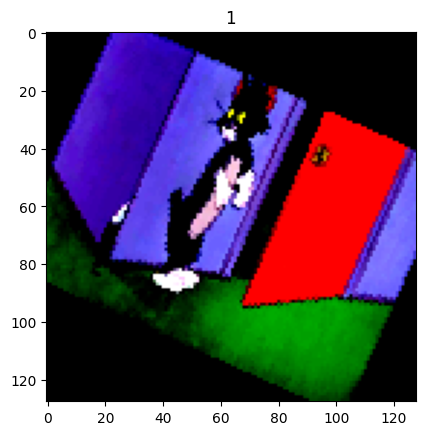

In [131]:
img,label=val_set[500]
plt.imshow(img.permute(1,2,0))
print(label)
plt.title(label)

In [132]:
image=img.unsqueeze(0)

with torch.no_grad():
  output=model(image)
_,pred=torch.max(output,1)
print("Predicted output: ",pred.item())
# Check if prediction is correct
if label == pred.item():
    print("✅ Model predicted correctly!")
else:
    print("❌ Model predicted incorrectly.")

Predicted output:  1
✅ Model predicted correctly!


#Now we'll calculate screentime

In [133]:
# Path to the full dataset (original backup)
full_data_path = "/content/drive/MyDrive/original_tom_and_jerry"

*This will save your model's learned weights in Google Drive as tom_and_jerry_cnn.pth.*

In [134]:
# Save the trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/tom_and_jerry_cnn.pth")
print("Model saved successfully!")

Model saved successfully!


*Before running inference on the full dataset, load the model*

In [135]:
# Load the trained model
model = CNNModel()  # Initialize the CNN model
model.load_state_dict(torch.load("/content/drive/MyDrive/tom_and_jerry_cnn.pth", map_location=torch.device('cpu')))
model.eval()  # Set model to evaluation mode
print("Model loaded successfully!")

Model loaded successfully!


<ipython-input-135-a5d589a0499a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/tom_and_jerry_cnn.pth", map_locati

In [136]:
# Define transformation (same as training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [137]:
frame_paths = sorted(glob.glob(os.path.join(full_data_path, "**", "*.jpg"), recursive=True))

In [138]:
print(f"Total images found: {len(frame_paths)}")
print("Sample images:", frame_paths[:5])  # Print first 5 image paths

Total images found: 5478
Sample images: ['/content/drive/MyDrive/original_tom_and_jerry/jerry/frame100.jpg', '/content/drive/MyDrive/original_tom_and_jerry/jerry/frame1032.jpg', '/content/drive/MyDrive/original_tom_and_jerry/jerry/frame1033.jpg', '/content/drive/MyDrive/original_tom_and_jerry/jerry/frame1034.jpg', '/content/drive/MyDrive/original_tom_and_jerry/jerry/frame1035.jpg']


In [144]:
# Initialize class counts
class_counts = {0: 0, 1: 0, 2: 0, 3: 0}  # Assuming class 0=Jerry, 1=Tom, 2=Both, 3=Neither
fps = 1  # Change this if your video has a different FPS

In [145]:
# Classifies an image using the trained model.
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

In [146]:
# Iterate over all frames and classify them
for i, frame_path in enumerate(frame_paths):
    pred_class = predict_image(frame_path, model, transform)
    class_counts[pred_class] += 1
    if i % 500 == 0:  # Print progress every 500 frames
        print(f"Processed {i}/{len(frame_paths)} frames...")

Processed 0/5478 frames...
Processed 500/5478 frames...
Processed 1000/5478 frames...
Processed 1500/5478 frames...
Processed 2000/5478 frames...
Processed 2500/5478 frames...
Processed 3000/5478 frames...
Processed 3500/5478 frames...
Processed 4000/5478 frames...
Processed 4500/5478 frames...
Processed 5000/5478 frames...


In [142]:
# Convert frame counts to screen time (seconds)
screen_time = {k: v / fps for k, v in class_counts.items()}

In [143]:
# Print Results
print("\n--- Screen Time Results ---")
print(f"Total Frames Processed: {sum(class_counts.values())}")
print(f"Jerry Screen Time: {screen_time[0]:.2f} seconds")
print(f"Tom Screen Time: {screen_time[1]:.2f} seconds")
print(f"Both Characters: {screen_time[2]:.2f} seconds")
print(f"Neither Character: {screen_time[3]:.2f} seconds")


--- Screen Time Results ---
Total Frames Processed: 5478
Jerry Screen Time: 45.88 seconds
Tom Screen Time: 84.50 seconds
Both Characters: 72.46 seconds
Neither Character: 25.42 seconds
